# Non Negative Matrix Factorization for Topic Modeling

In [20]:
# load libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from sklearn.decomposition import NMF
from collections import Counter
from gensim.models.nmf import Nmf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
sns.set_style('darkgrid')
from time import time

## CNN news data-set

In [21]:
# Load the articles
df= pd.read_csv(r'C:\Users\l\Desktop\nlp_project\dataset\cnn_data_4_5.csv')  
df=df.drop(['url', 'title', 'date'], axis=1)
df.head()


print(df.head())
print(df.shape)

                                                body
0  In the new system "Canton becomes Guangzhou an...
1  Saudi Arabia's decision to open its taps comes...
2  The promise of unlimited support for markets f...
3  The country where the pandemic began was almos...
4  Now, some of the same companies that binged on...
(301, 1)


In [22]:
# Get the word count

def word_count(text):
    return len(str(text).split(' '))

word_count = df['body'].apply(word_count)
word_count.mean()
print("Word count mean %0.3f" % word_count.mean())


Word count mean 731.834


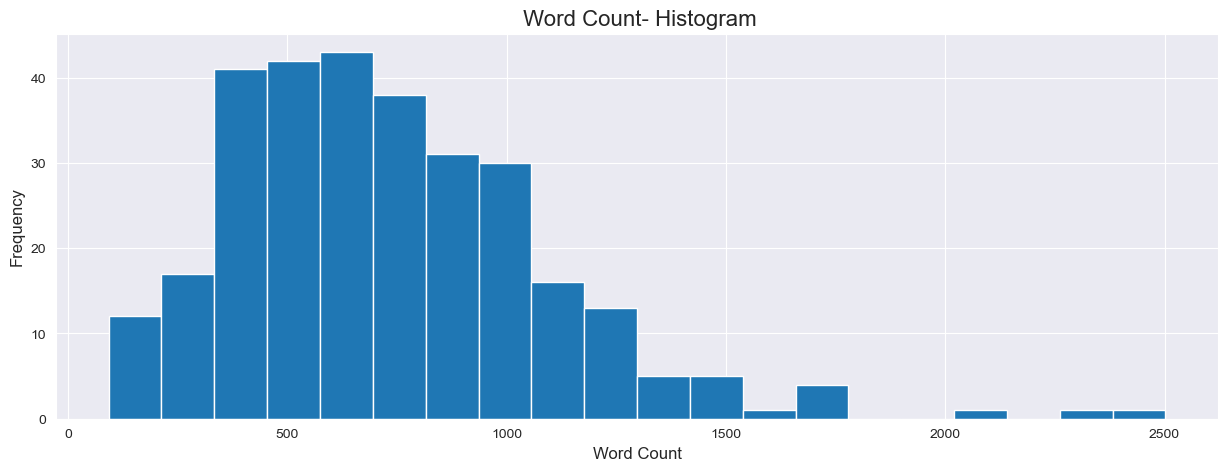

In [23]:
# Plot a hist of the word counts
fig = plt.figure(figsize=(15,5))

plt.hist(word_count,bins=20,)

plt.title(' Word Count- Histogram', fontsize=16)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Word Count', fontsize=12)

plt.show()

In [24]:
# Splits words on white spaces (leaves contractions intact) and splits out
# trailing punctuation

def clean_text(text):
    text = TweetTokenizer().tokenize(text)
    text = [each.lower() for each in text]
    text = [re.sub('[0-9]+', '', each) for each in text]
    text = [SnowballStemmer('english').stem(each) for each in text]
    text = [w for w in text if w not in ENGLISH_STOP_WORDS]
    text = [each for each in text if len(each) > 1]
    text = [each for each in text if ' ' not in each]
    return text

# Clean the text
df['clean_text'] = df['body'].apply(clean_text)
df.head()

,body,clean_text
0,"In the new system ""Canton becomes Guangzhou an...","[new, canton, becom, guangzhou, tientsin, beco..."
1,Saudi Arabia's decision to open its taps comes...,"[saudi, arabia, decis, open, tap, come, talk, ..."
2,The promise of unlimited support for markets f...,"[promis, unlimit, support, market, feder, rese..."
3,The country where the pandemic began was almos...,"[countri, pandem, began, complet, shut, late, ..."
4,"Now, some of the same companies that binged on...","[compani, bing, buyback, line, receiv, taxpaye..."


In [25]:
# Get the top 20 most common words among all the articles
p_text = df['clean_text']

# Flaten the list of lists
p_text = [item for sublist in p_text for item in sublist]

# Top 20
top_20 = pd.DataFrame(Counter(p_text).most_common(20),columns=['word', 'frequency'])

top_20

,word,frequency
0,said,1922
1,compani,972
2,busi,750
3,peopl,718
4,work,693
5,coronavirus,564
6,week,542
7,worker,536
8,time,508
9,like,500


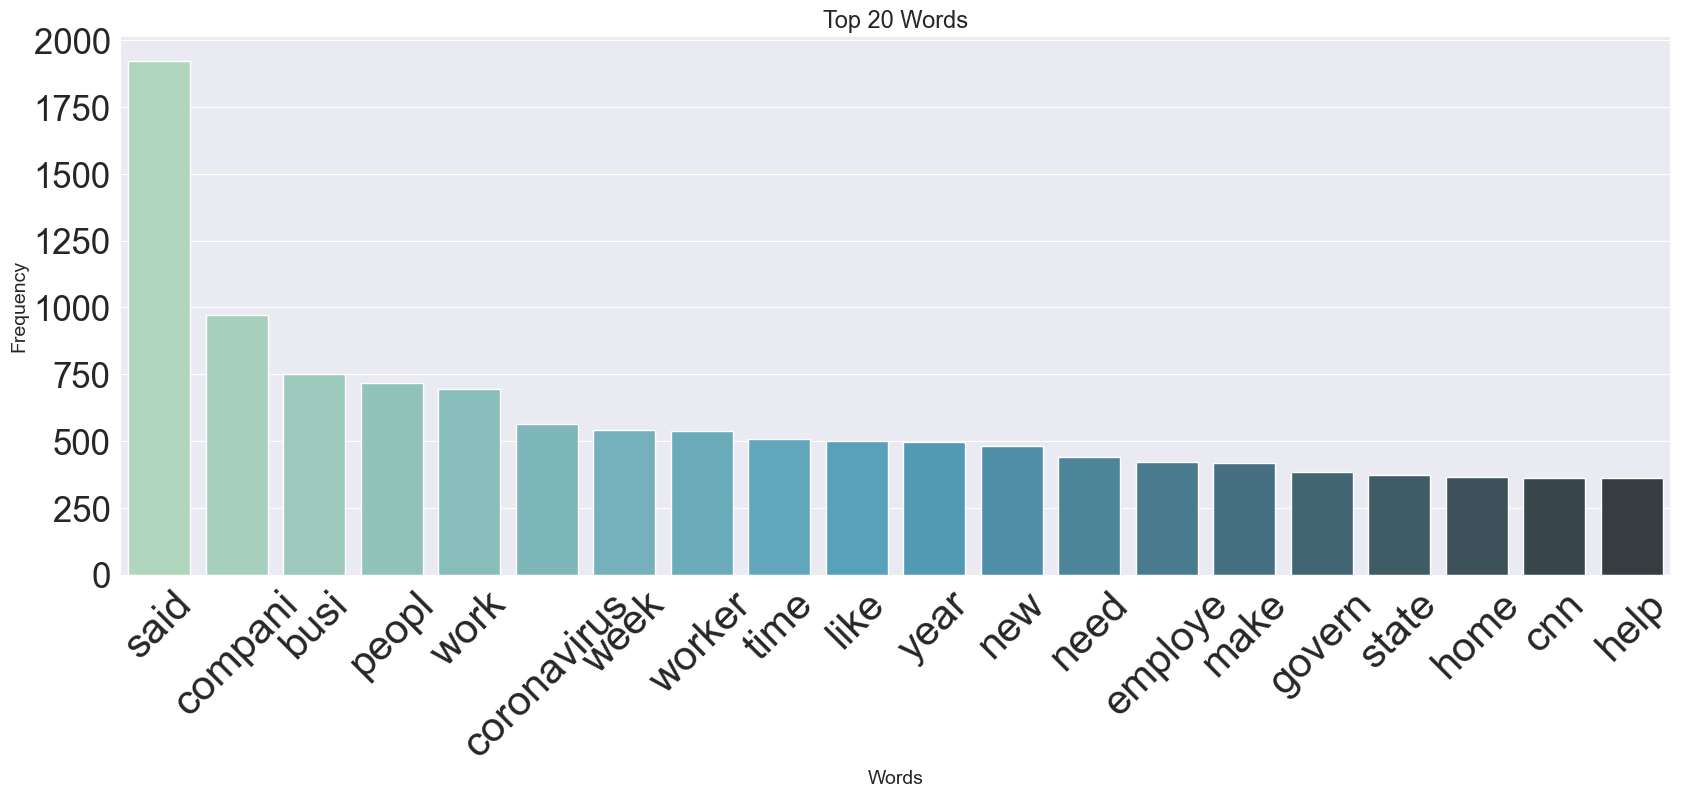

In [26]:
# Plot a bar chart for the top 20 most frequently occuring words
fig = plt.figure(figsize=(20,7))

g = sns.barplot(
    x='word',
    y='frequency',
    data=top_20,
    palette='GnBu_d'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=45,
    fontsize=14
)

plt.yticks(fontsize=25)
plt.xticks(fontsize=30)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 20 Words', fontsize=17)

plt.show()

In [27]:
# Get the number of unique words after processing
num_unique_words = len(set(p_text))
num_unique_words

9172

In [28]:
# Use Gensim's NMF to get the best num of topics via coherence score
texts1 = df['clean_text']

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts1)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(no_below=3,no_above=0.85,keep_n=5000)

# Create the bag-of-words format (list of (token_id, token_count))
corpus1 = [dictionary.doc2bow(text) for text in texts1]

texts2 = df['clean_text'][:200]
corpus2 = [dictionary.doc2bow(text) for text in texts2]

texts3 = df['clean_text'][:100]
corpus3 = [dictionary.doc2bow(text) for text in texts3]

texts4 = df['clean_text'][:50]
corpus4 = [dictionary.doc2bow(text) for text in texts4]

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores_abc = []


corpus_list=[corpus1, corpus2, corpus3, corpus4]
text_list=[texts1, texts2, texts3, texts4]
corpus_text_list = zip(corpus_list, text_list)

for corpus,texts in corpus_text_list:
    nmf = Nmf(
        corpus=corpus,
        num_topics=10,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42)
    # Run the coherence model to get the score
    cm = CoherenceModel(model=nmf,texts=texts,dictionary=dictionary, coherence='c_v')
    coherence_scores_abc.append(round(cm.get_coherence(), 5))
    

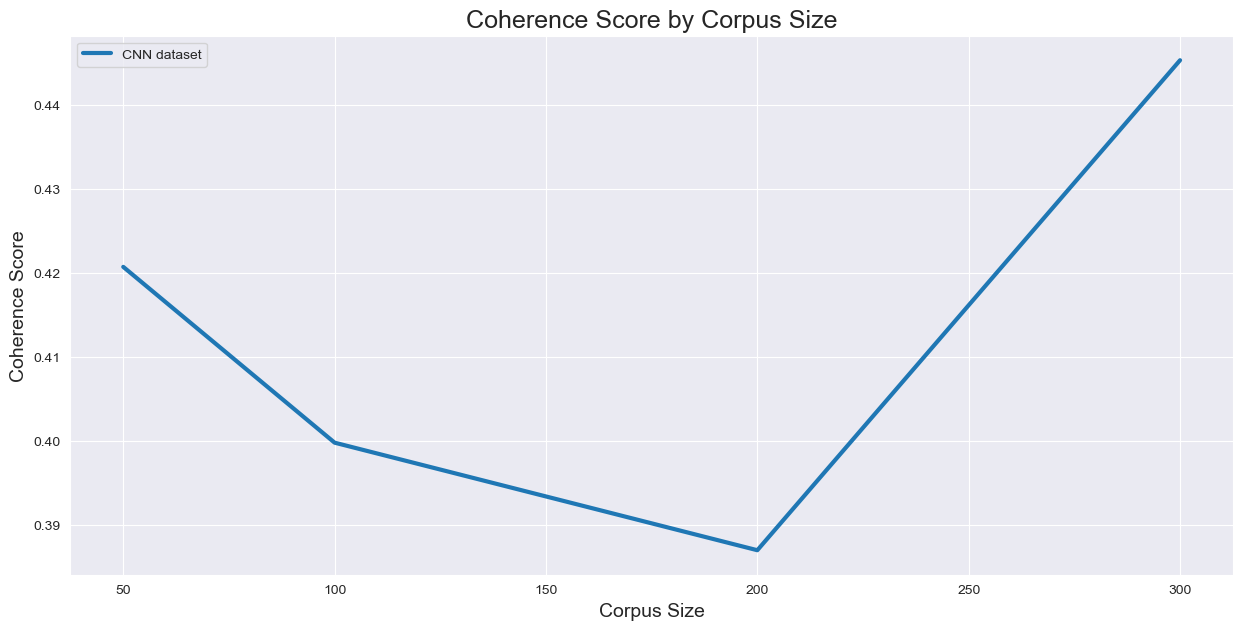

In [29]:
# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot([50,100,200,300],coherence_scores_abc,linewidth=3,label='CNN dataset')


plt.xlabel("Corpus Size", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Corpus Size', fontsize=18)
plt.legend()


plt.show()

In [32]:
# Use Gensim's NMF to get the best num of topics via coherence score
texts = df['clean_text']

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
# below 3 -> 3 samles
#abouve 0.085-> from zv size of the corpus
dictionary.filter_extremes(no_below=3,no_above=0.85, keep_n=5000)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 31, 3))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores_cnn = []
t0 = time()



# chunksize-> batch size
# passes-> epocs
# minimum_probability-> for tpoic to be drop out when normalize is True
# normalize-> normalize the resulte for  coherence
# kappa -> learning rate
for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42)
    # Run the coherence model to get the score
    cm = CoherenceModel(model=nmf,texts=texts,dictionary=dictionary,coherence='c_v')
    coherence_scores_cnn.append(round(cm.get_coherence(), 5))
    
print("NMF done in %0.3fs" % (time() - t0))

NMF done in 179.486s


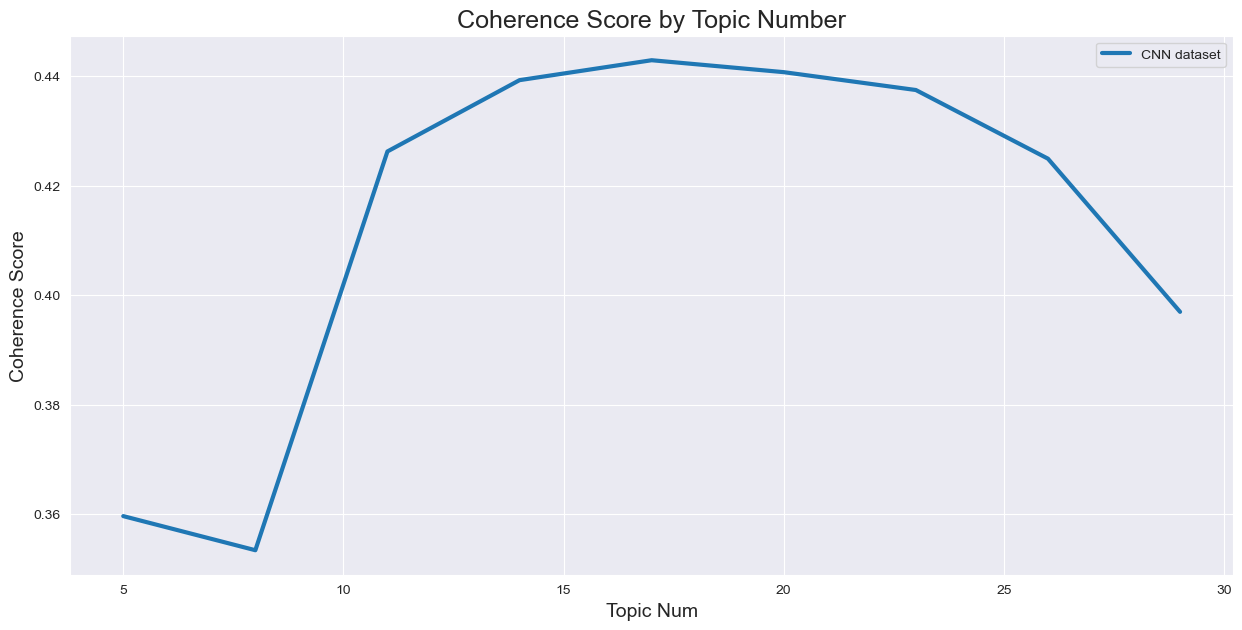

In [33]:
# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(topic_nums,coherence_scores_cnn,linewidth=3,label='CNN dataset')

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number', fontsize=18)
plt.legend()


plt.show()

In [34]:
print(max(coherence_scores_cnn))
max_index_cnn = (coherence_scores_cnn.index(max(coherence_scores_cnn)) + 1 )*3+5


0.4429


In [35]:

# Now use the number of topics with the 
# highest coherence score to run the 
# sklearn nmf model

texts = df['clean_text']

# Create the tfidf weights
# min_df-> token with freqance less then 3
# max_df-> tiken with larger 0.85 corpus
# ngram_range= (1, 2) means unigrams and bigrams
tfidf_vectorizer = TfidfVectorizer(min_df=3, max_df=0.85, max_features=5000, preprocessor=' '.join)

tfidf = tfidf_vectorizer.fit_transform(texts)

# Save the feature names for later to create topic summaries
tfidf_fn = tfidf_vectorizer.get_feature_names()

# Run the nmf model
nmf = NMF( n_components= max_index_cnn, random_state=42 ).fit(tfidf)

C:\Users\l\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [36]:
# Use the top words for each cluster by tfidf weight
# to create 'topics'

# Getting a df with each topic by document
#docweights = nmf.transform(tfidf_vectorizer.transform(texts))

n_top_words = 6
def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]  

def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)

topic_df = topic_table( nmf, tfidf_fn, n_top_words).T

def whitespace_tokenizer(text): 
    pattern = r"(?u)\b\w\w+\b" 
    tokenizer_regex = RegexpTokenizer(pattern)
    tokens = tokenizer_regex.tokenize(text)
    return tokens

# Funtion to remove duplicate words
def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist

# Cleaning up the top words to create topic summaries
topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
topic_df['topics'] = topic_df['topics'].apply(lambda x: whitespace_tokenizer(x)) # tokenize
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets


In [37]:
# Create a df with only the created topics and topic num
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']

print(topic_df[:8])

   topic_num                                     topics
0          0  instacart worker shopper custom gig order
1          1       oil saudi price arabia russia barrel
2          2       loan payment small busi bank mortgag
3          3        trump fox news brief hanniti presid
4          4   airlin flight passeng carrier fli travel
5          5            app user zoom data googl inform
6          6   ventil ford devic patient product design
7          7           store retail close open maci tjx


In [38]:

# Predicting the topic for an unseen article

# Load the unseen articles for prediction

df_new = pd.read_csv(r'C:\Users\l\Desktop\nlp_project\dataset\unseen_cnn_articles.csv')
df_new=df_new.drop(['url', 'title', 'date'], axis=1)

# Process the text
df_new['processed_text'] = df_new['body'].apply(clean_text)

new_texts = df_new['processed_text']

# Transform the new data with the fitted models
tfidf_new = tfidf_vectorizer.transform(new_texts)
X_new = nmf.transform(tfidf_new)

# Get the top predicted topic
predicted_topics = [np.argsort(each)[::-1][0] for each in X_new]

# Add to the df
df_new['pred_topic_num'] = predicted_topics

df_new

,body,processed_text,pred_topic_num
0,"Nuro, based in Mountain View, California, is n...","[nuro, base, mountain, view, california, abl, ...",11
1,"A deadly pandemic, an economic implosion and a...","[dead, pandem, econom, implos, new, way, work,...",9
2,"As a freelance copywriter for outdoor, fitness...","[freelanc, copywrit, outdoor, fit, brand, spri...",10
3,There's a lot of revisionist history being wri...,"[lot, revisionist, histori, written, right, lo...",3
4,The company confirmed to CNN Business that the...,"[compani, confirm, cnn, busi, new, shipment, n...",15


## ABC news data-set

In [39]:
# Load the articles
df= pd.read_csv(r'C:\Users\l\Desktop\nlp_project\dataset\abc_news-data.csv')  
df=df.drop(['publish_date'], axis=1)
df= df.sample(n=300005, random_state=1, ignore_index=True)
df_test= df[300000:300005]
df=df[:-5]
print(df.head())
print(df.shape)

                                   headline_text
0           proteas take aim at aussie top order
1         toro energy to acquire uranium project
2  botmaster arrested over computer spam network
3                       darcys old wares lucknow
4                      police probe teen bashing
(300000, 1)


In [40]:
# Get the word count

def word_count(text):
    return len(str(text).split(' '))

word_count = df['headline_text'].apply(word_count)
word_count.mean()
print("Word count mean %0.3f" % word_count.mean())


Word count mean 6.405


In [41]:
# Splits words on white spaces (leaves contractions intact) and splits out
# trailing punctuation

def clean_text(text):
    text = TweetTokenizer().tokenize(text)
    text = [each.lower() for each in text]
    text = [re.sub('[0-9]+', '', each) for each in text]
    text = [SnowballStemmer('english').stem(each) for each in text]
    text = [w for w in text if w not in ENGLISH_STOP_WORDS]
    text = [each for each in text if len(each) > 1]
    text = [each for each in text if ' ' not in each]
    return text

# Clean the text
df['clean_text'] = df['headline_text'].apply(clean_text)
df.head()

,headline_text,clean_text
0,proteas take aim at aussie top order,"[protea, aim, aussi, order]"
1,toro energy to acquire uranium project,"[toro, energi, acquir, uranium, project]"
2,botmaster arrested over computer spam network,"[botmast, arrest, comput, spam, network]"
3,darcys old wares lucknow,"[darci, old, ware, lucknow]"
4,police probe teen bashing,"[polic, probe, teen, bash]"


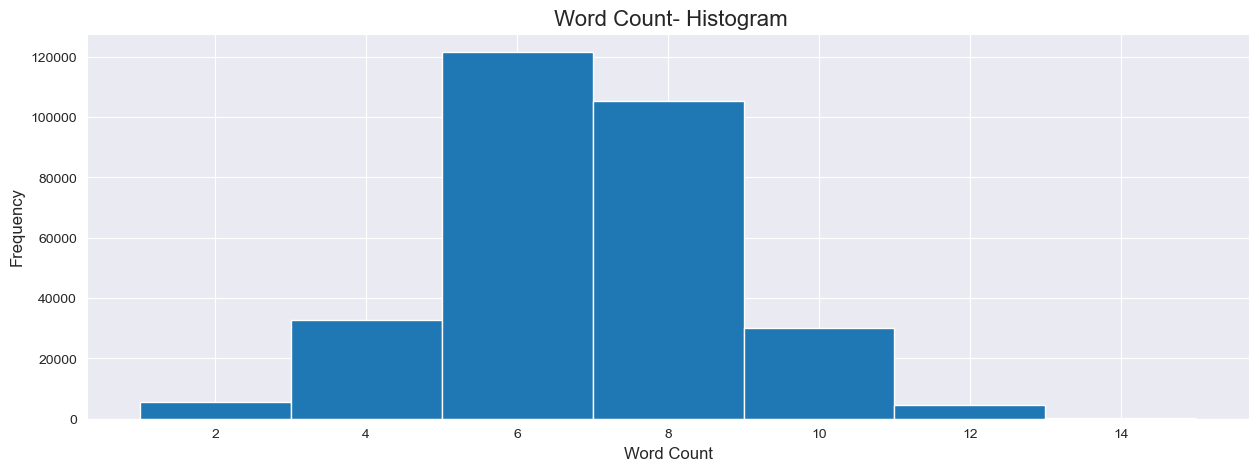

In [42]:
# Plot a hist of the word counts
fig = plt.figure(figsize=(15,5))

plt.hist(word_count,bins=7,)

plt.title(' Word Count- Histogram', fontsize=16)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Word Count', fontsize=12)

plt.show()

In [43]:
# Get the top 20 most common words among all the articles
p_text = df['clean_text']

# Flaten the list of lists
p_text = [item for sublist in p_text for item in sublist]

# Top 20
top_20 = pd.DataFrame(Counter(p_text).most_common(20),columns=['word', 'frequency'])

top_20

,word,frequency
0,polic,9823
1,man,8111
2,new,7886
3,say,6679
4,plan,5983
5,charg,5301
6,council,5044
7,govt,4804
8,court,4583
9,win,4429


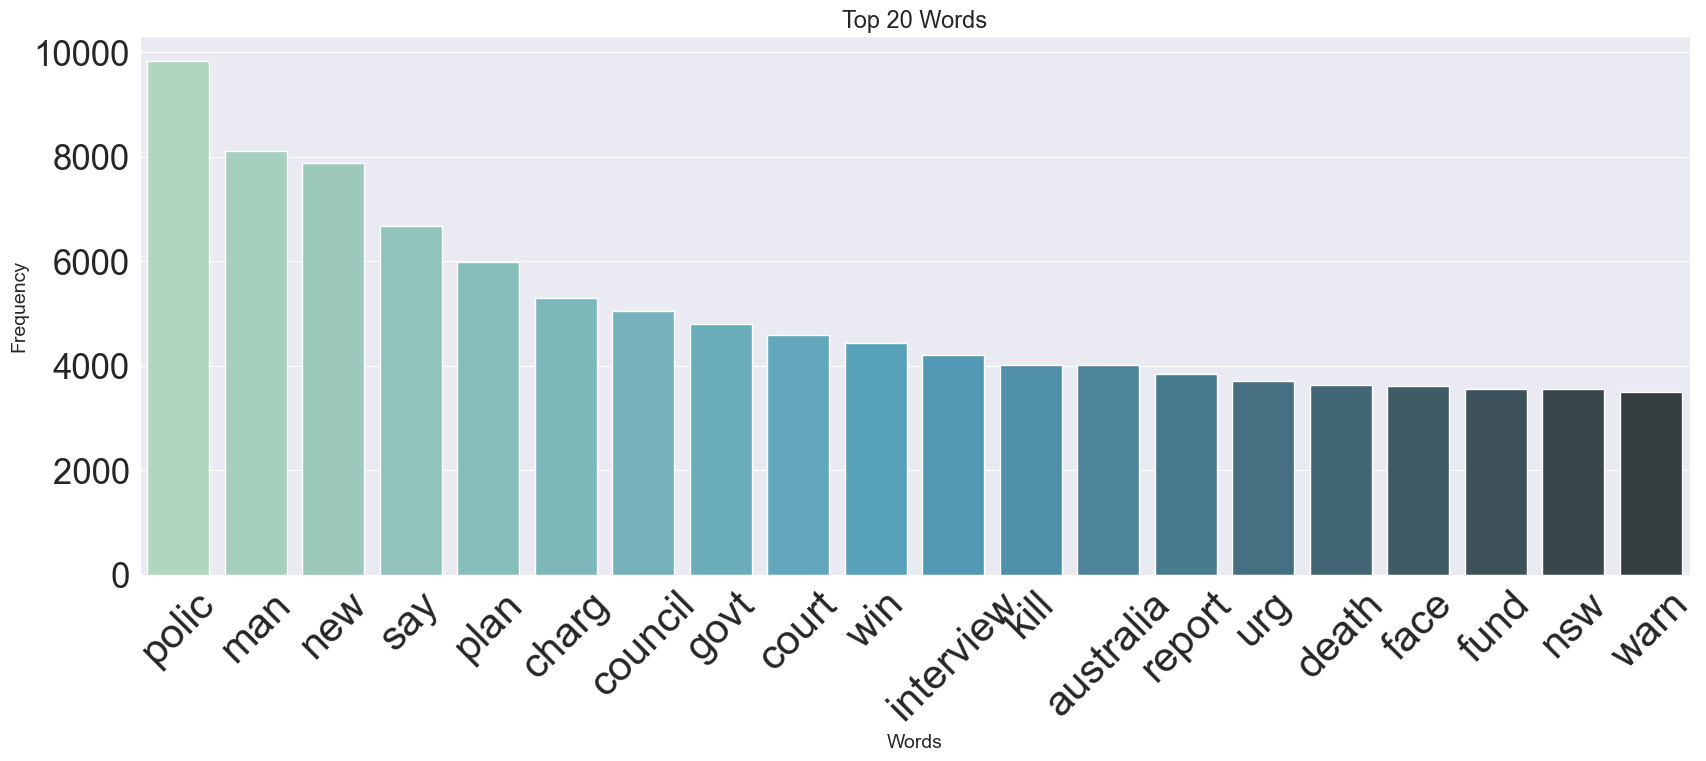

In [44]:
# Plot a bar chart for the top 20 most frequently occuring words
fig = plt.figure(figsize=(20,7))

g = sns.barplot(
    x='word',
    y='frequency',
    data=top_20,
    palette='GnBu_d'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=45,
    fontsize=14
)

plt.yticks(fontsize=25)
plt.xticks(fontsize=30)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 20 Words', fontsize=17)

plt.show()

In [45]:
# Get the number of unique words after processing
num_unique_words = len(set(p_text))
num_unique_words

39058

### Coherence scores by corpus size

In [46]:
# Use Gensim's NMF to get the best num of topics via coherence score
texts1 = df['clean_text']

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts1)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(no_below=3,no_above=0.85,keep_n=5000)

# Create the bag-of-words format (list of (token_id, token_count))
corpus1 = [dictionary.doc2bow(text) for text in texts1]

texts2 = df['clean_text'][:200000]
corpus2 = [dictionary.doc2bow(text) for text in texts2]

texts3 = df['clean_text'][:100000]
corpus3 = [dictionary.doc2bow(text) for text in texts3]

texts4 = df['clean_text'][:50000]
corpus4 = [dictionary.doc2bow(text) for text in texts4]

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores_abc = []


corpus_list=[corpus1, corpus2, corpus3, corpus4]
text_list=[texts1, texts2, texts3, texts4]
corpus_text_list = zip(corpus_list, text_list)

for corpus,texts in corpus_text_list:
    nmf = Nmf(
        corpus=corpus,
        num_topics=10,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42)
    # Run the coherence model to get the score
    cm = CoherenceModel(model=nmf,texts=texts,dictionary=dictionary, coherence='c_v')
    coherence_scores_abc.append(round(cm.get_coherence(), 5))
    

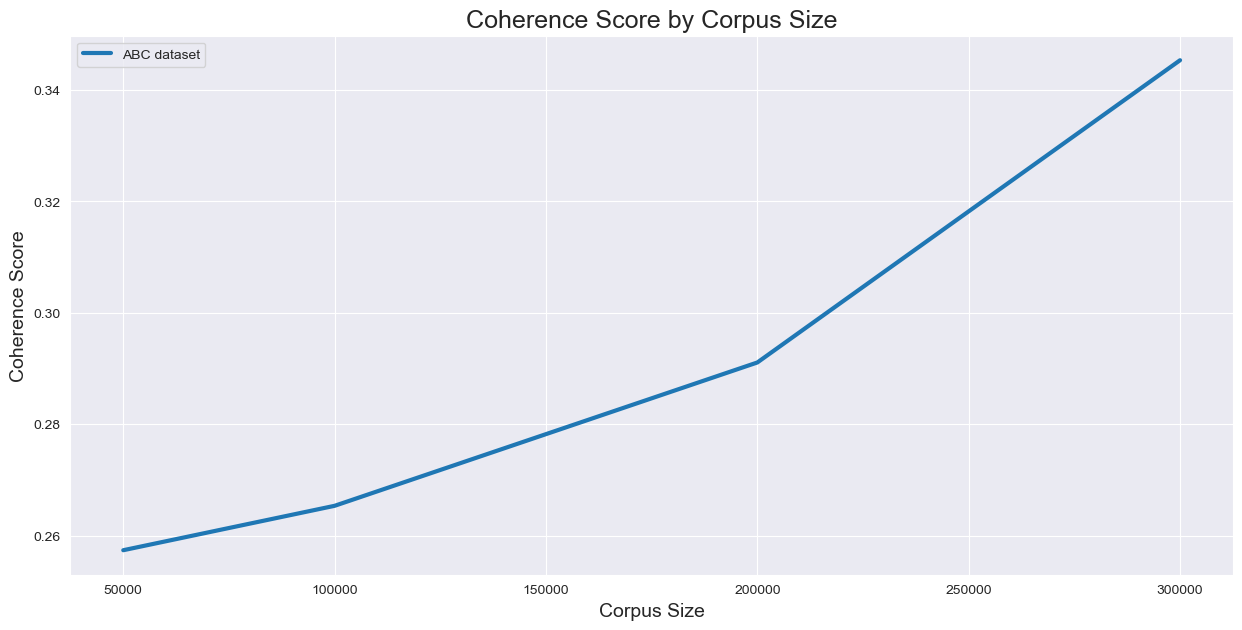

In [47]:
# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot([50000,100000,200000,300000],coherence_scores_abc,linewidth=3,label='ABC dataset')


plt.xlabel("Corpus Size", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Corpus Size', fontsize=18)
plt.legend()


plt.show()

In [48]:
coherence_scores_abc

[0.25741, 0.26538, 0.2911, 0.34534]

In [49]:
# Use Gensim's NMF to get the best num of topics via coherence score
texts = df['clean_text']

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(no_below=3,no_above=0.85,keep_n=5000)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 31, 3))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores_abc = []
t0 = time()

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42)
    # Run the coherence model to get the score
    cm = CoherenceModel(model=nmf,texts=texts,dictionary=dictionary, coherence='c_v')
    coherence_scores_abc.append(round(cm.get_coherence(), 5))
    
print("NMF done in %0.3fs." % (time() - t0))

NMF done in 685.793s.


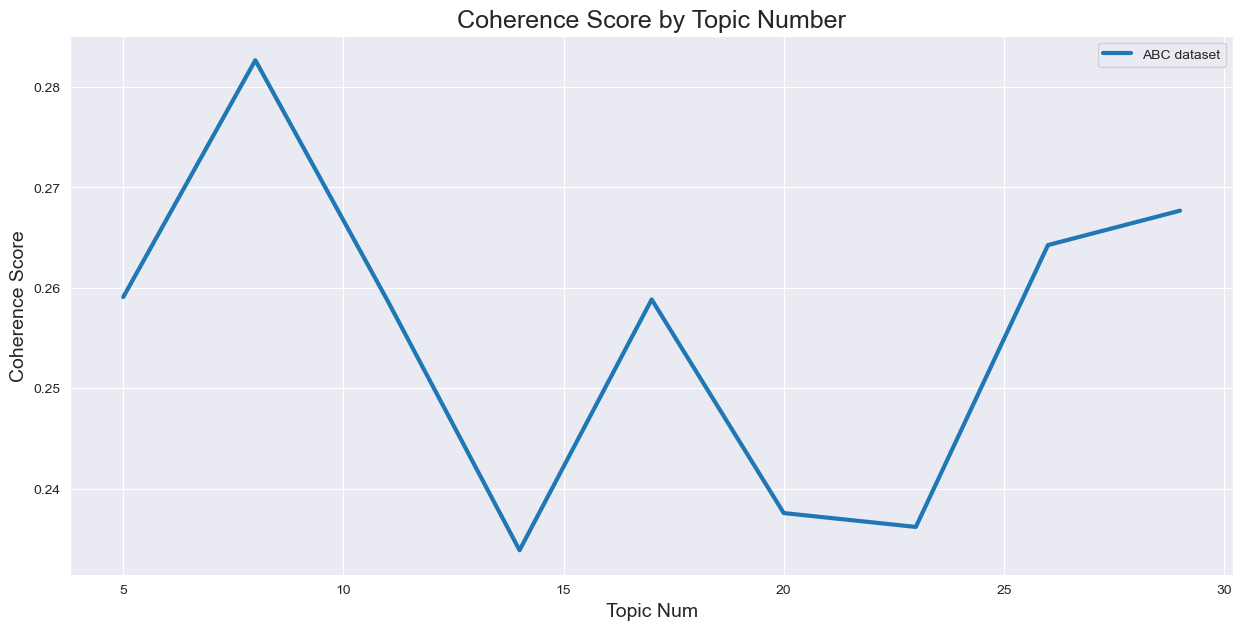

In [50]:
# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(topic_nums,coherence_scores_abc,linewidth=3,label='ABC dataset')

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number', fontsize=18)
plt.legend()


plt.show()

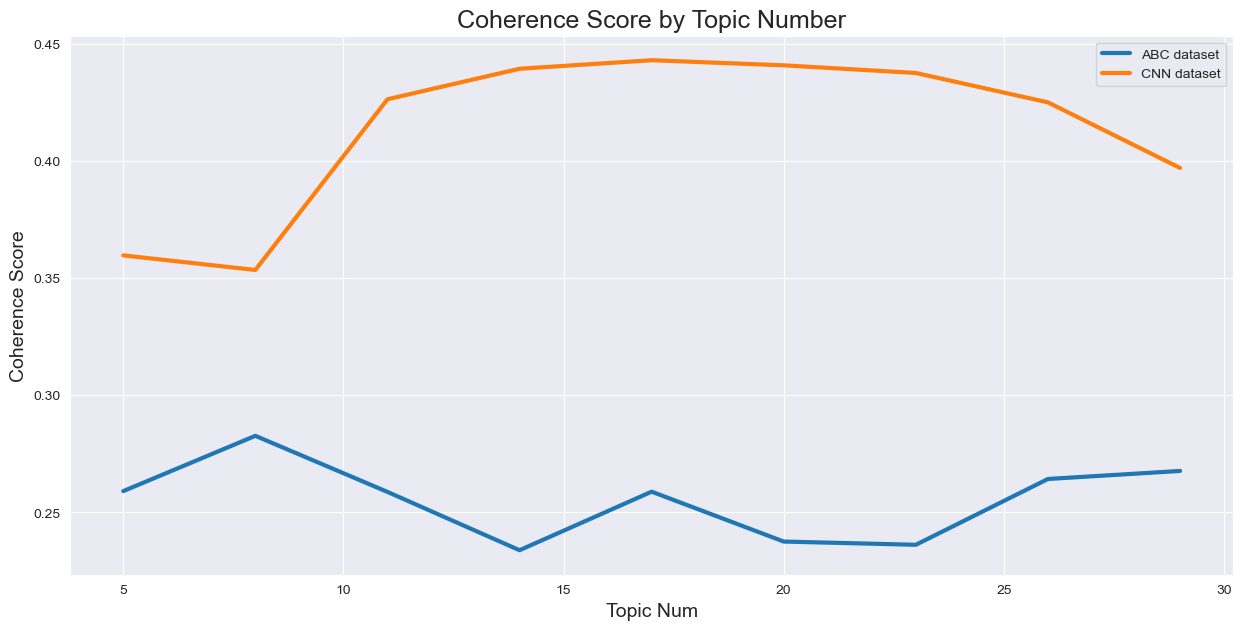

In [51]:
# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(topic_nums,coherence_scores_abc,linewidth=3,label='ABC dataset')
plt.plot(topic_nums,coherence_scores_cnn,linewidth=3,label='CNN dataset')

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number', fontsize=18)
plt.legend()


plt.show()

In [52]:
print(max(coherence_scores_abc))
max_index_abc = (coherence_scores_abc.index(max(coherence_scores_abc))+ 1 )*3 + 5

0.28267


In [53]:
texts = df['clean_text']

# Create the tfidf weights
# min_df-> token with freqance less then 3
# max_df-> tiken with larger 0.85 corpus
tfidf_vectorizer = TfidfVectorizer(min_df=3, max_df=0.85, max_features=5000, preprocessor=' '.join)


tfidf = tfidf_vectorizer.fit_transform(texts)

# Save the feature names for later to create topic summaries
tfidf_fn = tfidf_vectorizer.get_feature_names()

# Run the nmf model
nmf = NMF( n_components= 8, random_state=42 ).fit(tfidf)

C:\Users\l\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [54]:

n_top_words = 6

topic_df = topic_table( nmf, tfidf_fn, n_top_words).T

# Cleaning up the top words to create topic summaries
topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
topic_df['topics'] = topic_df['topics'].apply(lambda x: whitespace_tokenizer(x)) # tokenize
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets


In [55]:
# Create a df with only the created topics and topic num
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']

print(topic_df[:8])

   topic_num                                  topics
0          0        man charg murder court face jail
1          1  interview extend michael david ben nrl
2          2          plan council govt say fund urg
3          3  polic investig probe miss search death
4          4          new year zealand law home open
5          5           crash kill car die fatal road
6          6        win australia day world cup open
7          7       abc news rural busi market nation


In [56]:

# Showing the 3 matrices we get witn nmf
A = tfidf_vectorizer.transform(texts)
W = nmf.components_
H = nmf.transform(A)

print('A = {} x {}'.format(A.shape[0], A.shape[1]))
print('W = {} x {}'.format(W.shape[0], W.shape[1]))
print('H = {} x {}'.format(H.shape[0], H.shape[1]))

A = 300000 x 5000
W = 8 x 5000
H = 300000 x 8


In [58]:

# Predicting the topic for an unseen article

# Process the text
df_test['processed_text'] = df_test['headline_text'].apply(clean_text)

new_texts = df_test['processed_text']

# Transform the new data with the fitted models
tfidf_new = tfidf_vectorizer.transform(new_texts)
X_new = nmf.transform(tfidf_new)

# Get the top predicted topic
predicted_topics = [np.argsort(each)[::-1][0] for each in X_new]

# Add to the df
df_test['pred_topic_num'] = predicted_topics

df_test

,headline_text,processed_text,pred_topic_num
300000,sudanese rebels release soldiers police icrc,"[sudanes, rebel, releas, soldier, polic, icrc]",3
300001,desal builder was paid extra for missed deadline,"[desal, builder, paid, extra, miss, deadlin]",3
300002,report to back wollongong stadium revamp,"[report, wollongong, stadium, revamp]",7
300003,teachers applaud smaller kindergarten classes,"[teacher, applaud, smaller, kindergarten, class]",2
300004,darwins test venue receives icc blessing,"[darwin, test, venu, receiv, icc, bless]",6
